# FSL Generative adversarial encoder

In [1]:
from google.colab import drive
#drive.mount("/content/gdrive/", force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
root_path = 'gdrive/My Drive/MINI_PROJECT' #phd/FSL_Model_keras'
# root_path = 'gdrive/My Drive/phd' #/kksFiles'
print(os.getcwd())
os.chdir(root_path)
!ls
#jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888  --NotebookApp.port_retries=0
#Moreover We show that the overall common feature can be taken as dummy class for cluster boundary smoothing which improves the generalization.

/content
100_epochs.jpeg  FSL_Generative_adversarial_encoder.ipynb  mini-imagenet-cache-train.pkl
40_epochs.jpeg	 mini-imagenet-cache-test.pkl		   mini-imagenet-cache-val.pkl


In [3]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import os
import keras
import numpy as np
import numpy.random as rng
import random
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Sequential,load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers as rg
from tensorflow.keras import callbacks as cb

#import tensorflow_probability as tfp



In [4]:
# import os
# from accelerate.utils import write_basic_config

# write_basic_config()  # Write a config file
# #os._exit(00)

In [5]:
import cv2
import numpy as np
from scipy import signal

''' img=cv2.imread("images/lion.jpg")
print(img.shape)

plt.subplot(1,2,1)
plt.imshow(img[:,:,0], cmap='gray')

k=np.ones((7,7))
k=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
b = signal.convolve2d(img[:,:,0], k, mode='same')

plt.subplot(1,2,2)
plt.imshow(b, cmap='gray') '''

' img=cv2.imread("images/lion.jpg")\nprint(img.shape)\n\nplt.subplot(1,2,1)\nplt.imshow(img[:,:,0], cmap=\'gray\')\n\nk=np.ones((7,7))\nk=np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])\nb = signal.convolve2d(img[:,:,0], k, mode=\'same\')\n\nplt.subplot(1,2,2)\nplt.imshow(b, cmap=\'gray\') '

# Initialization

In [6]:

lr = 0.001
eps = 1e-12

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#build convnet to use in each siamese 'leg'
def conv_net(dim):
    convnet = Sequential()
    #convnet.add(tf.keras.layers.RandomFlip( mode=HORIZONTAL_AND_VERTICAL, seed=None, **kwargs))
    for i in range(4):

        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet


def normalise(xx):
  global noise
  std = tf.reshape(tf.math.reduce_std(xx,axis=1),(-1,1))
  meanFeature = tf.reshape(tf.reduce_mean(xx,axis=1),(-1,1))
  out_feature = (xx- meanFeature)/std
  return out_feature


def proto_dist(x):  # Negative softmax distance measure
    feature, pred = x
    pred_dist = tf.reduce_sum(pred ** 2, axis=1, keepdims=True)
    feature_dist = tf.reduce_sum(feature ** 2, axis=1, keepdims=True)
    #print(pred_dist.shape);  print(feature_dist.shape)
    dot = tf.matmul(pred, tf.transpose(feature))
    #print(dot.shape)
    return tf.nn.softmax(-(tf.sqrt(pred_dist + tf.transpose(feature_dist) - 2 * dot)))

def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

def reduce_tensor(x):
    y=tf.reduce_mean(x, axis=1)
    return y

def reshape_query(x):  # reshape query output to  dimention 64*query,1
    y=tf.reshape(x, [-1, tf.shape(x)[-1]])
    return y

def Bias_net(dim):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size =(3,1),padding ='same', activation ='linear', input_shape = dim))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 8, kernel_size =(3,1),padding ='same', activation ='linear'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1, kernel_size =(3,1), padding ='same', activation='linear'))
    return model


# load dataset

In [7]:
import pandas as pd
df = pd.read_pickle("mini-imagenet-cache-train.pkl")
x_train=np.array(df['image_data']); y_train = df['class_dict']
#x_train = np.reshape(np.mean(x_train,axis=3),(-1,84,84,1)).astype('float32')
x_train = np.reshape(x_train,(-1,84,84,3)).astype('float32')
x_train /=255 #(x_train1-127)/127
print(x_train.shape, len(y_train))
#.....................................................................
df = pd.read_pickle("mini-imagenet-cache-val.pkl")
x_val=df['image_data']; y_val = df['class_dict']
#x_val = np.reshape(np.mean(x_val,axis=3),(-1,84,84,1)).astype('float32')
x_val = np.reshape(x_val,(-1,84,84,3)).astype('float32')
x_val  /=255 #(x_val1-127)/127  # 255
print(x_val.shape, len(y_val))
#..........................................................
df = pd.read_pickle("mini-imagenet-cache-test.pkl")
x_test=df['image_data']; y_test = df['class_dict']
#x_test = np.reshape(np.mean(x_test,axis=3),(-1,84,84,1)).astype('float32')
x_test = np.reshape(x_test,(-1,84,84,3)).astype('float32')
x_test /= 255
#x_test=(x_test1-127)/127
print(x_test.shape, len(y_test))

(38400, 84, 84, 3) 64
(9600, 84, 84, 3) 16
(12000, 84, 84, 3) 20


# Mask

In [8]:
n=84
mask=np.ones((n,n,3))*1.0  #, dtype="float32"
for i in range(n):
  for j in range(n):
      for k in range(3):
       mask[i,j,k]= np.round(np.tanh(((np.abs(n/2-i)+np.abs(n/2-j))/n)),2) #+0.05
      #a[i]= np.round(1/(1+np.exp(-np.abs(n/2-i)/n)),2)
      #a[i]= np.round(np.tanh(np.abs(n/2-i)/n),2)**3

print(mask[n//2-2,n//2-2,:],np.max(mask))
# maskk=np.repeat(np.reshape(mask, (1,n,n,3)),3, axis=0)
# print(mask.shape,maskk.shape)

[0.05 0.05 0.05] 0.76


In [9]:
def saveData(data,file_name):
  open_file = open(file_name, "wb")
  pickle.dump(data, open_file)
  open_file.close()

def loadData(file_name):
  open_file = open(file_name, "rb")
  matchInd = pickle.load(open_file)
  open_file.close()

In [10]:
# generatedTrain = loadData("trainGenerated.pkl")
# generatedVal  = loadData("valGenerated.pkl")
# generatedTest= loadData("testGenerated.pkl")


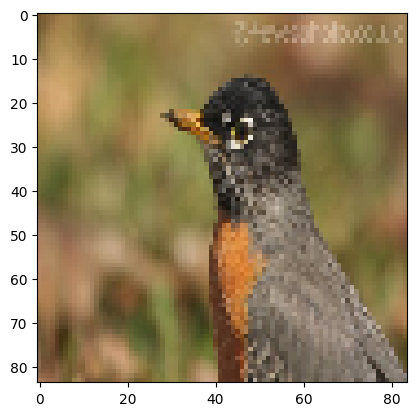

In [11]:
plt.imshow(x_train[600])

# Data generation for generator



(10, 84, 84, 3) (10, 84, 84, 3) (10, 84, 84, 3)


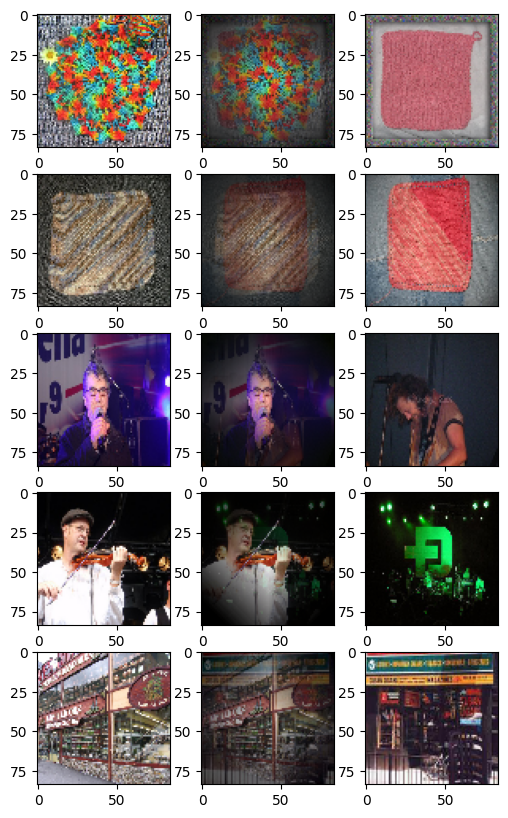

In [12]:
k=0.01
#del LabelTrain, LabelVal, LabelTest,Data_GeneratorRaviLabel1,loadLabel1,Data_GeneratorRaviLabel
#del Data_GeneratorRaviLabel
randLayer=np.random.normal(0.1, 0.05,size=(84,84,3))
idxx=random.sample(list(y_test), 5)

import cv2
def flip (img):
  img=np.reshape(img, (84,84,3))
  img2= cv2.flip(img, 1)
  return img2 #np.expand_dims(img2, axis=-1)
s=5
def cv2_zoom(img):
    m,n,p=img.shape
    cropped_img = img[s:m-s, s:n-s,:]
    result = cv2.resize(cropped_img, (84, 84))
    return result

class Data_GeneratorRaviLabel(tf.keras.utils.Sequence):

    #def __init__(self, datatype='train', dim=(32,32), n_channels=1, way=20, shot=1, query=1, num_batch=10):
    def __init__(self, datatype='train', dim=(84,84,1), num_per_class=1, n_channels=1, way = 3,shot=1, num_batch=10):
        'Initialization'
        global k,idxx, mask
        self.data=x_train
        self.y=y_train

        if(datatype=='val'):
          self.data=x_val
          self.y=y_val

        if(datatype=='test'):
          self.data=x_test
          self.y=y_test

        self.dim = dim
        self.n_channels = n_channels
        #print(num_per_class)
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.shot = shot
        self.way = way
        #self.noise1=np.abs(np.random.normal(0,0.3,(84,84)))
        self.maskk=np.repeat(np.reshape(mask[:,:,:], (1,84,84,3)),self.way*self.shot, axis=0)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'
        X_query,  X_query1, X_query2 = self.__data_generation()
        return X_query, X_query1, X_query2

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        X_sample=[]; X_query=[]; X_query1=[]; X_query2=[];
        idx=random.sample(list(self.y), self.way)
        label = np.zeros((self.way*self.shot, self.way))
        layr1 = random.sample([0,1,2], 1)[0]
        layr2 = (layr1+1)%3 #random.sample([0,1,2], 1)[0]

        for i in range(self.way):
          sample_idx1 = random.sample(self.y[idx[i]], 2*self.shot)

          for s in range(self.shot):
              imgg = self.data[sample_idx1[s]]
              X_query.append(imgg)
              img2 = imgg.copy()
              img01 = self.data[sample_idx1[self.shot+s]]  #  #
              #img2[:,:,layr2] = img01[:,:,layr2]
              #img2[:,:,layr2]=img2[:,:,layr2]*(1-mask[:,:,layr1])+ img01[:,:,layr2]*(mask[:,:,layr1]+0.1)
              #img2=img2*(1-mask)+ img01*(mask)
              img2=1.5*img2*(1-mask) - 0.5*(img2-img01*(mask))
              X_query1.append(img2)
              X_query2.append(img01)


        return  np.array(X_query), np.array(X_query1), np.array(X_query2)  #X_noise,
train_way = 5
shot = 2
n=600

val_loader = Data_GeneratorRaviLabel(datatype='train', num_per_class=n,way = train_way,shot=shot, num_batch=1)
x,y,z = val_loader[0]
print(x.shape,y.shape,z.shape)

img1,img2,img3=val_loader[0]
fig = plt.figure(figsize=(6,10))
p=3
for j in range(5):
    plt.subplot(5,p,p*j+1)
    plt.imshow(img1[j, :, :,:] )
    plt.subplot(5,p,p*j+2)
    plt.imshow(img2[j, :, :,:] )
    plt.subplot(5,p,p*j+3)
    plt.imshow(img3[j, :, :,:] )

    #plt.axis('off')
plt.show()


# Generator

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 64)        1792      
                                                                 
 layer_normalization (Layer  (None, 84, 84, 64)        128       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 84, 84, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 84, 64)        36928     
                                                                 
 layer_normalization_1 (Lay  (None, 84, 84, 64)        128       
 erNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 84, 84, 64)        0

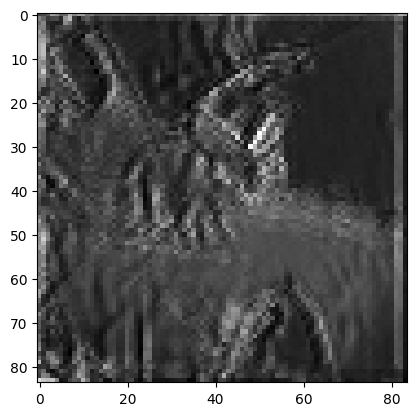

In [13]:

def make_generator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3),  padding='same', input_shape=dim))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())
    #model.add(augmentLayer())
    #model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(3,3), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(64,(3,3), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64,(1,1), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(3, (1,1), padding='same',use_bias=False, activation='sigmoid'))

    #model.add(layers.ReLU())
    return model

dim=(84, 84, 3)
generator = make_generator_model(dim)
print(generator.summary())
noise=y #np.concatenate((x,y),3)
generated_image = np.abs(generator([noise], training=False))
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

#Discriminator

In [14]:
#del discriminator
def make_discriminator_model():  #576
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3), padding='valid',   input_shape=[84,84,3]))
    model.add(layers.LayerNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(2,2))

    model.add(layers.Conv2D(64, (3,3), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.ReLU())
    model.add(layers.MaxPooling2D(2,2))
    #model.add(Attention(ch=64))

    model.add(layers.Conv2D(64, (3,3), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, (1,1), padding='same'))
    model.add(layers.LayerNormalization())
    model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Activation('tanh'))

    model.add(layers.Flatten())
    #model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = make_discriminator_model()
print(discriminator.summary())
img=tf.reshape(generated_image,(-1,84,84,3))
decision = discriminator(img)
print(np.max(decision),np.min(decision),np.mean(decision))
#print (decision)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 82, 82, 64)        1792      
                                                                 
 layer_normalization_4 (Lay  (None, 82, 82, 64)        128       
 erNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 82, 82, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 41, 41, 64)        0         
 D)                                                              
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 64)        36928     
                                                                 
 layer_normalization_5 (Lay  (None, 41, 41, 64)       

# Image pair training

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
dim=(84,84,6)
generator = make_generator_model(dim)
discriminator = make_discriminator_model()

#generator= load_model('Model/generator_miniImagemet_layr1_layr2.h5')
def cosine_distances1(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.reduce_sum(normalize_b*normalize_a, axis=1) #tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

@tf.function
def train_step(image_batch1, image_batch2,image_batch3):
  #noise_dim=(image_batch1.shape[0],1000)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      dxx = discriminator(image_batch2, training=True)
      dx = discriminator(image_batch1, training=True)
      #noise=np.concatenate((image_batch1, image_batch3), axis=1)
      noise=tf.concat((image_batch1, image_batch3), axis=-1)
      #noise= image_batch1 # tf.concat([image_batch1,image_batch2],3) #image_batch1*0.7+image_batch2*0.3 #
      gx = generator(noise, training=True)
      dgx = discriminator(gx, training=True)

      gen_dist1=cosine_distances1([dgx,dxx])
      gen_dist2=proto_dist([dgx,dx])

      dis_dist1 = proto_dist([dxx,dx])
      dis_dist2 = cosine_distances1([dxx,dxx])

      gen_loss1 = cross_entropy(tf.ones_like(gen_dist1), gen_dist1) #generator_loss(fake_output)+fake_loss1
      gen_loss = gen_loss1 + cross_entropy(tf.identity(gen_dist2), gen_dist2)

      disc_loss1 = cross_entropy(tf.identity(dis_dist1), dis_dist1) #discriminator_loss(real_output1, fake_output)
      disc_loss2 = cross_entropy(tf.ones_like(dis_dist2), dis_dist2)
      disc_loss = disc_loss1 + disc_loss2 + cross_entropy(tf.zeros_like(gen_dist1), gen_dist1)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss, disc_loss, disc_loss1+disc_loss2

In [19]:
train_way = 10
shot = 1
num_batch=100

#generator1= generator
def train( epochs):
  gen_loss=0; disc_loss=0;i=0;
  global gLoss, dLoss1, gLoss1, dLoss2
  for epoch in range(epochs):
    #start = time.time()
    gen_loss=0; disc_loss=0; disc_loss0=0
    dataset = Data_GeneratorRaviLabel(datatype='train', num_per_class=n,way = train_way,shot=shot, num_batch=100)
    for image_batch1, image_batch2,image_batch3 in dataset:
       gen_loss1, disc_loss1, disc_loss11 = train_step(image_batch1, image_batch2,image_batch3)
       gen_loss +=gen_loss1; disc_loss += disc_loss1; disc_loss0 += disc_loss11
    i=i+1
    gen_loss = gen_loss/num_batch; disc_loss = disc_loss/num_batch; disc_loss0 = disc_loss0/num_batch
    print(i,gen_loss, disc_loss,disc_loss0)
    gLoss1.append(gen_loss); dLoss1.append(disc_loss); dLoss2.append(disc_loss0)

EPOCHS = 60
gLoss1=[]; dLoss1=[];dLoss2=[]

train( EPOCHS)

1 tf.Tensor(1.1343518, shape=(), dtype=float32) tf.Tensor(2.023505, shape=(), dtype=float32) tf.Tensor(1.0047446, shape=(), dtype=float32)
2 tf.Tensor(1.136768, shape=(), dtype=float32) tf.Tensor(2.0132914, shape=(), dtype=float32) tf.Tensor(1.002469, shape=(), dtype=float32)
3 tf.Tensor(1.1444271, shape=(), dtype=float32) tf.Tensor(2.0107038, shape=(), dtype=float32) tf.Tensor(1.0064586, shape=(), dtype=float32)
4 tf.Tensor(1.1432275, shape=(), dtype=float32) tf.Tensor(2.0061355, shape=(), dtype=float32) tf.Tensor(1.0045053, shape=(), dtype=float32)
5 tf.Tensor(1.1509765, shape=(), dtype=float32) tf.Tensor(1.997248, shape=(), dtype=float32) tf.Tensor(1.0051519, shape=(), dtype=float32)
6 tf.Tensor(1.1530524, shape=(), dtype=float32) tf.Tensor(1.9986253, shape=(), dtype=float32) tf.Tensor(1.0079266, shape=(), dtype=float32)
7 tf.Tensor(1.1604213, shape=(), dtype=float32) tf.Tensor(1.9885979, shape=(), dtype=float32) tf.Tensor(1.0084966, shape=(), dtype=float32)
8 tf.Tensor(1.1602553, s

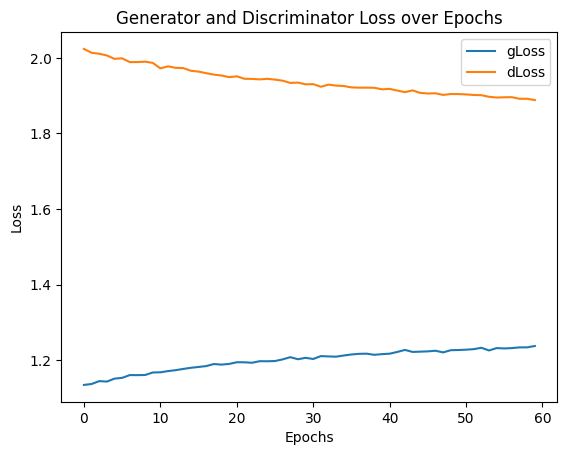

In [21]:
import matplotlib.pyplot as plt

# Assuming gLoss1 and dLoss1 contain the loss values

# Plot the loss values
plt.plot(gLoss1, label="gLoss")
plt.plot(dLoss1, label="dLoss")
plt.legend()
plt.title("Generator and Discriminator Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# Save the plot to a file
plt.savefig("new_100_epochs.jpeg")

# Display the plot
plt.show()


# Display

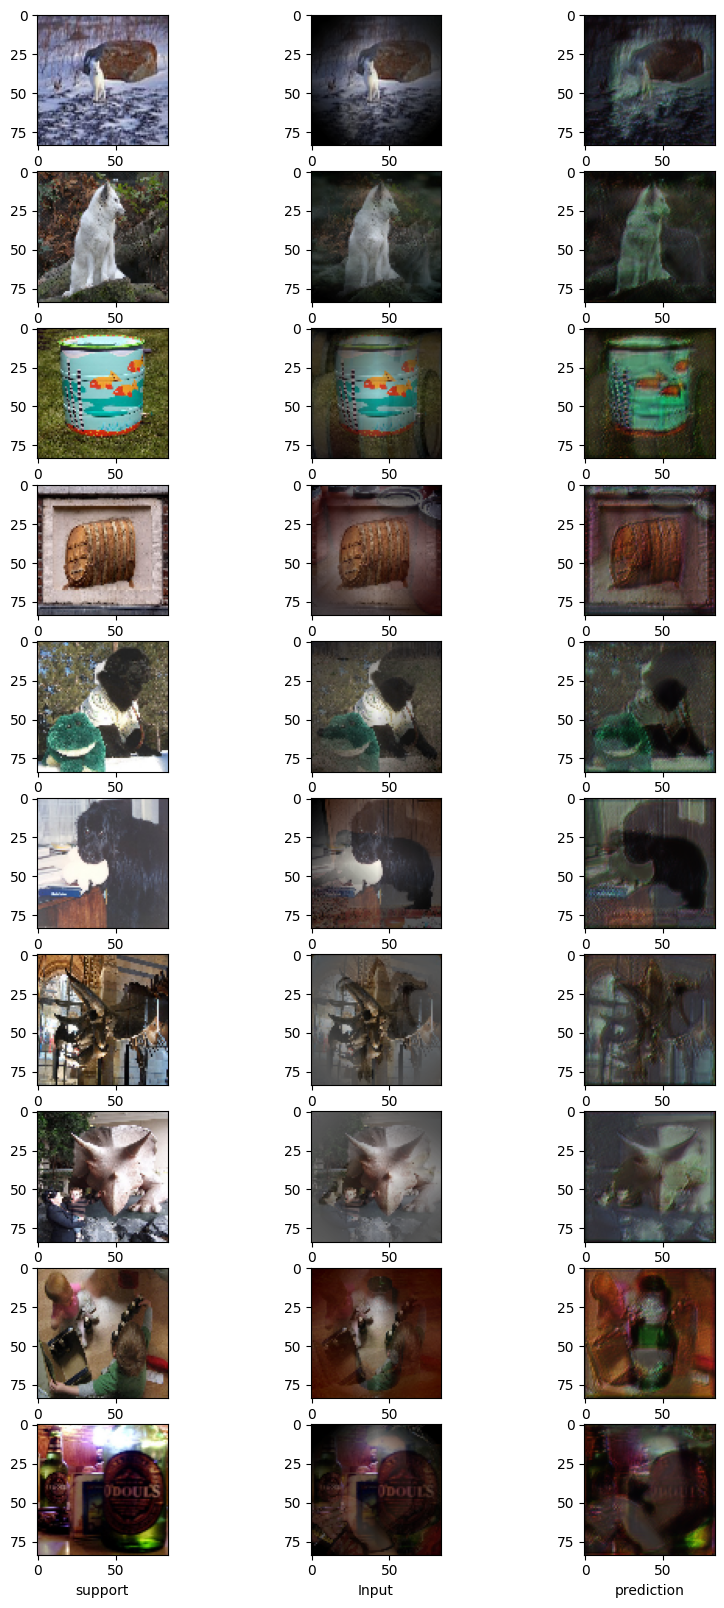

In [23]:

#generator1= load_model('Model/generator_miniImagemet_layr1_layr2.h5')
#generator.save('Model/generator_miniImagemet_layr1_layr2.h5')
train_way = 5
shot = 2

dataset = Data_GeneratorRaviLabel(way = train_way, datatype = 'train',  shot = shot, num_batch=1)
(image1, image2, image3) = dataset[0]
#noise=image1#tf.reduce_mean(tf.reshape(real_output,(-1,100,16)),axis=2)  #tf.concat([image1,image2],3) #image1*0.7+image2*0.3 #
noise=tf.concat((image1, image3), axis=-1)
predictions = generator(noise, training=False)

fig= plt.figure(figsize=(10,20))
k=10;p=3
for i in range(k):
    plt.subplot(k, p, p*i+1)
    plt.imshow(image1[i, :, :,:])
    #plt.axis('off')
    plt.xlabel('support')
    plt.subplot(k, p, p*i+2)
    plt.imshow(image2[i, :, :,:])
    #plt.axis('off')
    plt.xlabel('Input')
    plt.subplot(k, p, p*i+3)
    plt.imshow(predictions[i, :, :,:], cmap='gray')
    #plt.axis('off')
    plt.xlabel('prediction')

#plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
plt.show()
